In [1]:
%load_ext autoreload
%autoreload 2

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from hyperopt import hp, tpe, fmin, Trials
from tqdm import tqdm
# from tqdm.notebook import tqdm

from collections import OrderedDict, defaultdict
import itertools
from functools import partial
import datetime
from joblib import Parallel, delayed
import copy
import json

from data.dataloader import get_jhu_data, get_covid19india_api_data, get_rootnet_api_data
from data.processing import get_data

from models.seir.seir_testing import SEIR_Testing
from main.seir.optimiser import Optimiser
from main.seir.losses import Loss_Calculator
from main.seir.fitting import single_fitting_cycle, get_variable_param_ranges
from main.seir.forecast import get_forecast, create_region_csv, create_all_csvs, write_csv, plot_forecast
from utils.create_report import create_report

## Load Covid19india Data

In [5]:
dataframes = get_covid19india_api_data()

In [6]:
predictions_dict = {}

## Select Districts to fit on

In [8]:
districts_to_show = [('Maharashtra', 'Pune'), 
                     ('Maharashtra', 'Mumbai'), 
                     ('Rajasthan', 'Jaipur'), 
                     ('Gujarat', 'Ahmedabad'), 
                     ('Karnataka', 'Bengaluru Urban'),
                     ('Delhi', None)]

# districts_to_show = [('Maharashtra', 'Mumbai')]

## Perform M1 and M2 fits

fitting to data with "train_on_val" set to False ..


/home/users/sansiddh/anaconda3/envs/covid/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


splitting data ..
splitting data ..
train
           state district       date  hospitalised  total_infected  deceased  \
20  Maharashtra     Pune 2020-05-16        2035.0          3666.8     189.2   
21  Maharashtra     Pune 2020-05-17        2084.6          3818.2     195.2   
22  Maharashtra     Pune 2020-05-18        2188.8          4017.4     204.2   
23  Maharashtra     Pune 2020-05-19        2298.8          4221.0     213.4   
24  Maharashtra     Pune 2020-05-20        2438.2          4455.4     222.6   

    recovered  
20     1442.6  
21     1538.4  
22     1624.4  
23     1708.8  
24     1794.6  
val
          state district       date  hospitalised  total_infected  deceased  \
0  Maharashtra     Pune 2020-05-21        2583.4          4710.6     233.0   
1  Maharashtra     Pune 2020-05-22        2737.4          5032.8     244.6   
2  Maharashtra     Pune 2020-05-23        2901.2          5336.6     254.2   
3  Maharashtra     Pune 2020-05-24        3034.4          5670.6     

/home/users/sansiddh/anaconda3/envs/covid/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


splitting data ..
splitting data ..
train
           state district       date  hospitalised  total_infected  deceased  \
27  Maharashtra     Pune 2020-05-23        2901.2          5336.6     254.2   
28  Maharashtra     Pune 2020-05-24        3034.4          5670.6     263.8   
29  Maharashtra     Pune 2020-05-25        3171.0          5994.8     273.4   
30  Maharashtra     Pune 2020-05-26        3223.0          6335.0     282.0   
31  Maharashtra     Pune 2020-05-27        3493.0          6614.0     291.0   

    recovered  
27     2181.2  
28     2372.4  
29     2550.4  
30     2830.0  
31     2830.0  
val
 None
100%|██████████| 700/700 [00:28<00:00, 24.24trial/s, best loss: 3.970682780912991] 
best parameters
 {'E_hosp_ratio': 0.6314036443130536, 'I_hosp_ratio': 0.8454556134918216, 'P_fatal': 0.05114073859138391, 'P_severe': 0.45325469699866494, 'T_inc': 4.221266665905294, 'T_inf': 3.69515345720121, 'T_recov_severe': 22.148866511399206, 'lockdown_R0': 1.2095331582431608}
fitting t

/home/users/sansiddh/anaconda3/envs/covid/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


splitting data ..
splitting data ..
train
           state district       date  hospitalised  total_infected  deceased  \
20  Maharashtra   Mumbai 2020-05-16       14963.0         18889.8     692.6   
21  Maharashtra   Mumbai 2020-05-17       15657.0         19809.2     719.8   
22  Maharashtra   Mumbai 2020-05-18       16627.6         21098.6     757.0   
23  Maharashtra   Mumbai 2020-05-19       17691.0         22487.6     794.2   
24  Maharashtra   Mumbai 2020-05-20       18622.0         23907.8     829.2   

    recovered  
20     3234.2  
21     3432.4  
22     3714.0  
23     4002.4  
24     4456.6  
val
          state district       date  hospitalised  total_infected  deceased  \
0  Maharashtra   Mumbai 2020-05-21       19606.8         25404.2     867.6   
1  Maharashtra   Mumbai 2020-05-22       20731.4         27245.6     913.8   
2  Maharashtra   Mumbai 2020-05-23       21719.0         28816.4     950.8   
3  Maharashtra   Mumbai 2020-05-24       22515.0         30311.2     

/home/users/sansiddh/anaconda3/envs/covid/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


splitting data ..
splitting data ..
train
           state district       date  hospitalised  total_infected  deceased  \
27  Maharashtra   Mumbai 2020-05-23       21719.0         28816.4     950.8   
28  Maharashtra   Mumbai 2020-05-24       22515.0         30311.2     987.4   
29  Maharashtra   Mumbai 2020-05-25       23382.0         31664.6    1025.0   
30  Maharashtra   Mumbai 2020-05-26       23896.0         32974.0    1065.0   
31  Maharashtra   Mumbai 2020-05-27       24908.0         34018.0    1097.0   

    recovered  
27     6146.6  
28     6808.8  
29     7257.6  
30     8013.0  
31     8013.0  
val
 None
100%|██████████| 700/700 [00:29<00:00, 23.84trial/s, best loss: 5.842920335132014]
best parameters
 {'E_hosp_ratio': 0.583440207103171, 'I_hosp_ratio': 0.3705375687256225, 'P_fatal': 0.037325079643781504, 'P_severe': 0.624197992525726, 'T_inc': 4.84948395340343, 'T_inf': 3.486186211715621, 'T_recov_severe': 43.336215760821574, 'lockdown_R0': 1.0014417690851034}
fitting to d

/home/users/sansiddh/anaconda3/envs/covid/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


splitting data ..
splitting data ..
train
         state district       date  hospitalised  total_infected  deceased  \
20  Rajasthan   Jaipur 2020-05-16         521.6          1492.4      64.8   
21  Rajasthan   Jaipur 2020-05-17         549.2          1548.0      66.2   
22  Rajasthan   Jaipur 2020-05-18         572.4          1604.0      68.2   
23  Rajasthan   Jaipur 2020-05-19         572.0          1638.0      70.4   
24  Rajasthan   Jaipur 2020-05-20         560.0          1665.8      72.2   

    recovered  
20      906.0  
21      932.6  
22      963.4  
23      995.6  
24     1033.6  
val
        state district       date  hospitalised  total_infected  deceased  \
0  Rajasthan   Jaipur 2020-05-21         542.8          1688.6      74.0   
1  Rajasthan   Jaipur 2020-05-22         535.8          1723.6      75.6   
2  Rajasthan   Jaipur 2020-05-23         529.8          1756.2      76.8   
3  Rajasthan   Jaipur 2020-05-24         523.2          1791.0      78.0   
4  Rajasthan 

/home/users/sansiddh/anaconda3/envs/covid/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


splitting data ..
splitting data ..
train
         state district       date  hospitalised  total_infected  deceased  \
27  Rajasthan   Jaipur 2020-05-23         529.8          1756.2      76.8   
28  Rajasthan   Jaipur 2020-05-24         523.2          1791.0      78.0   
29  Rajasthan   Jaipur 2020-05-25         504.8          1828.4      79.6   
30  Rajasthan   Jaipur 2020-05-26         516.0          1860.0      81.0   
31  Rajasthan   Jaipur 2020-05-27         442.0          1902.0      83.0   

    recovered  
27     1149.6  
28     1189.8  
29     1244.0  
30     1263.0  
31     1377.0  
val
 None
100%|██████████| 700/700 [00:28<00:00, 24.27trial/s, best loss: 3.9462097075865414]
best parameters
 {'E_hosp_ratio': 0.18437960224431013, 'I_hosp_ratio': 0.5419849196272638, 'P_fatal': 0.040886975359841655, 'P_severe': 0.4019756700879959, 'T_inc': 4.96539273991342, 'T_inf': 3.680468560255413, 'T_recov_severe': 13.94451581142681, 'lockdown_R0': 1.4625621446124266}
fitting to data with 

/home/users/sansiddh/anaconda3/envs/covid/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


splitting data ..
splitting data ..
train
       state   district       date  hospitalised  total_infected  deceased  \
20  Gujarat  Ahmedabad 2020-05-16        4827.4          7865.6     503.2   
21  Gujarat  Ahmedabad 2020-05-17        5057.0          8272.6     525.4   
22  Gujarat  Ahmedabad 2020-05-18        5291.8          8681.6     550.0   
23  Gujarat  Ahmedabad 2020-05-19        5370.6          8942.6     575.2   
24  Gujarat  Ahmedabad 2020-05-20        5407.6          9203.4     599.4   

    recovered  
20     2535.0  
21     2690.2  
22     2839.8  
23     2996.8  
24     3196.4  
val
      state   district       date  hospitalised  total_infected  deceased  \
0  Gujarat  Ahmedabad 2020-05-21        5443.8          9467.0     622.2   
1  Gujarat  Ahmedabad 2020-05-22        5481.0          9734.0     646.4   
2  Gujarat  Ahmedabad 2020-05-23        5520.4         10008.8     670.4   
3  Gujarat  Ahmedabad 2020-05-24        5515.0         10287.2     695.6   
4  Gujarat  A

/home/users/sansiddh/anaconda3/envs/covid/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


splitting data ..
splitting data ..
train
       state   district       date  hospitalised  total_infected  deceased  \
27  Gujarat  Ahmedabad 2020-05-23        5520.4         10008.8     670.4   
28  Gujarat  Ahmedabad 2020-05-24        5515.0         10287.2     695.6   
29  Gujarat  Ahmedabad 2020-05-25        5507.4         10561.8     719.4   
30  Gujarat  Ahmedabad 2020-05-26        5473.0         10841.0     745.0   
31  Gujarat  Ahmedabad 2020-05-27        5383.0         11097.0     764.0   

    recovered  
27     3818.0  
28     4076.6  
29     4335.0  
30     4623.0  
31     4950.0  
val
 None
100%|██████████| 700/700 [00:29<00:00, 23.80trial/s, best loss: 1.5246604084561974]
best parameters
 {'E_hosp_ratio': 0.11372209041139318, 'I_hosp_ratio': 0.34570321814797866, 'P_fatal': 0.07973154329197758, 'P_severe': 0.4785948628417255, 'T_inc': 4.285117496010203, 'T_inf': 3.620446409776113, 'T_recov_severe': 22.41215719300017, 'lockdown_R0': 1.3894468096641304}
fitting to data with

/home/users/sansiddh/anaconda3/envs/covid/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


splitting data ..
splitting data ..
train
         state         district       date  hospitalised  total_infected  \
20  Karnataka  Bengaluru Urban 2020-05-16          94.0           212.6   
21  Karnataka  Bengaluru Urban 2020-05-17         100.2           224.0   
22  Karnataka  Bengaluru Urban 2020-05-18         104.8           233.6   
23  Karnataka  Bengaluru Urban 2020-05-19         111.0           242.0   
24  Karnataka  Bengaluru Urban 2020-05-20         118.4           251.4   

    deceased  recovered  
20       7.0      111.4  
21       7.2      116.6  
22       7.6      121.2  
23       8.0      123.0  
24       8.4      124.6  
val
        state         district       date  hospitalised  total_infected  \
0  Karnataka  Bengaluru Urban 2020-05-21         121.6           256.8   
1  Karnataka  Bengaluru Urban 2020-05-22         124.2           261.2   
2  Karnataka  Bengaluru Urban 2020-05-23         124.2           266.4   
3  Karnataka  Bengaluru Urban 2020-05-24         

/home/users/sansiddh/anaconda3/envs/covid/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


splitting data ..
splitting data ..
train
         state         district       date  hospitalised  total_infected  \
27  Karnataka  Bengaluru Urban 2020-05-23         124.2           266.4   
28  Karnataka  Bengaluru Urban 2020-05-24         122.8           270.4   
29  Karnataka  Bengaluru Urban 2020-05-25         122.4           274.6   
30  Karnataka  Bengaluru Urban 2020-05-26         118.0           278.0   
31  Karnataka  Bengaluru Urban 2020-05-27         122.0           284.0   

    deceased  recovered  
27       9.6      132.6  
28       9.8      137.8  
29      10.0      142.2  
30      10.0      150.0  
31      10.0      152.0  
val
 None
100%|██████████| 700/700 [00:28<00:00, 24.75trial/s, best loss: 5.229606480015923]
best parameters
 {'E_hosp_ratio': 0.002745534962713396, 'I_hosp_ratio': 0.29193277615763547, 'P_fatal': 0.0633395900116765, 'P_severe': 0.6918375700351506, 'T_inc': 4.534008323839288, 'T_inf': 3.8124657267891893, 'T_recov_severe': 27.62446481126684, 'lockdo

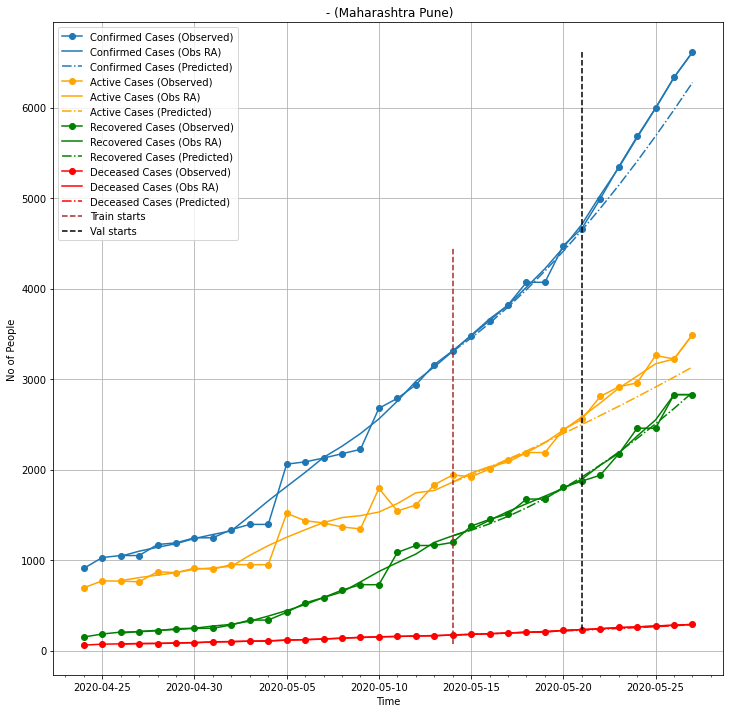

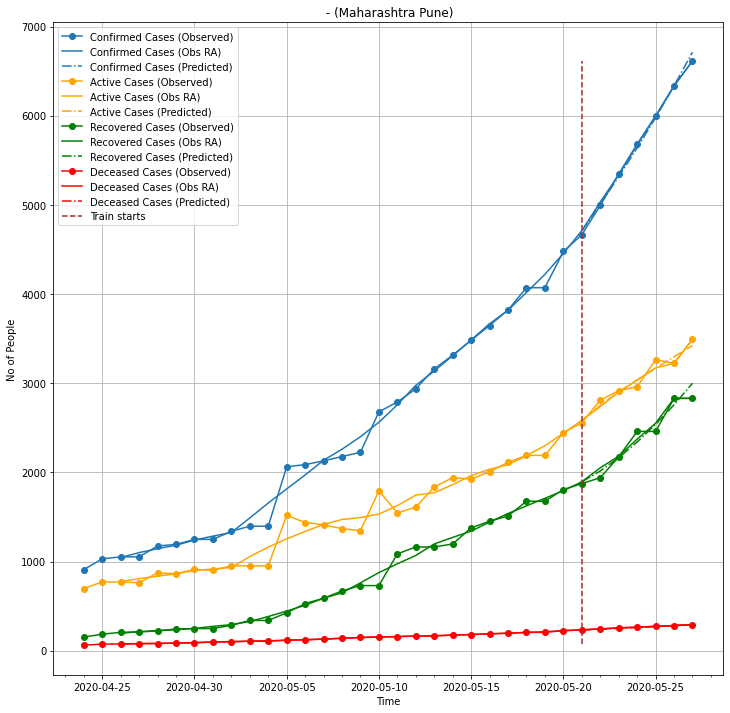

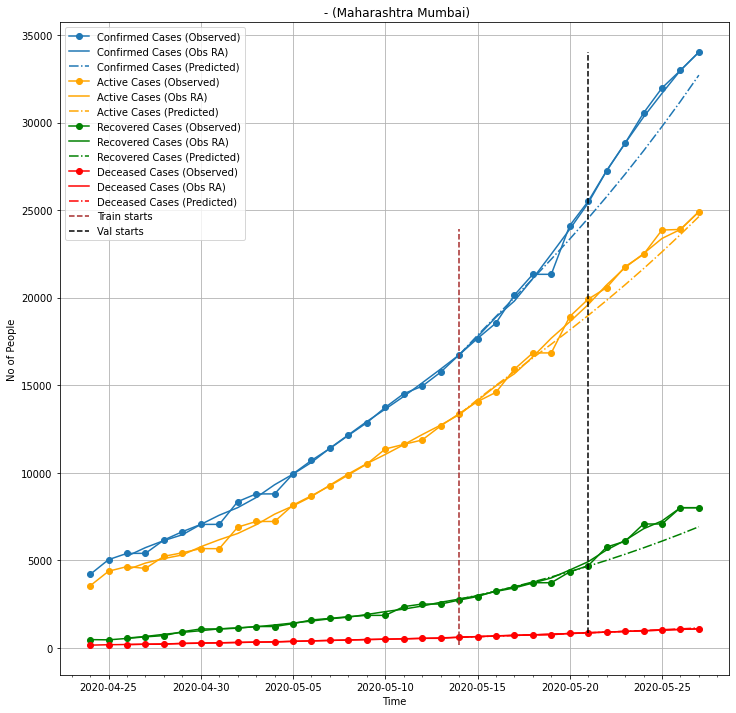

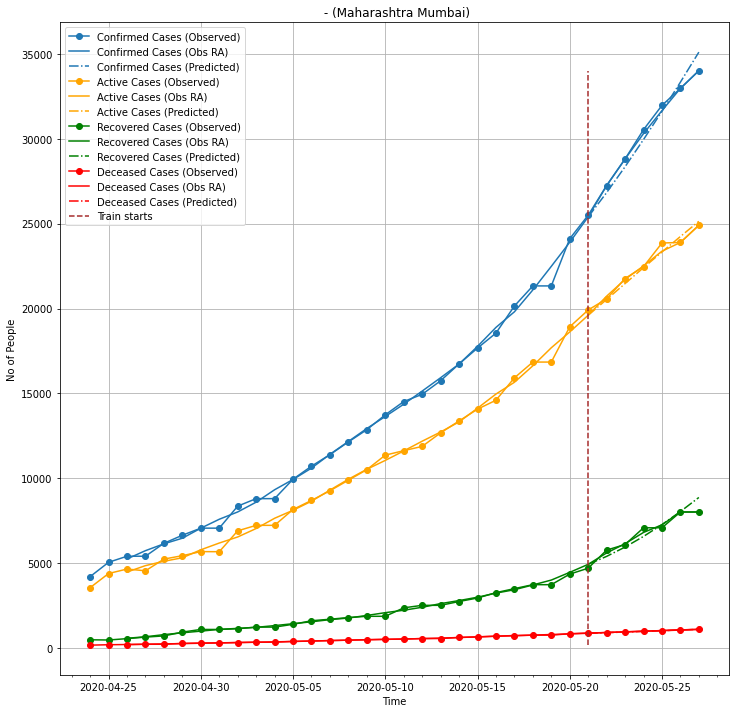

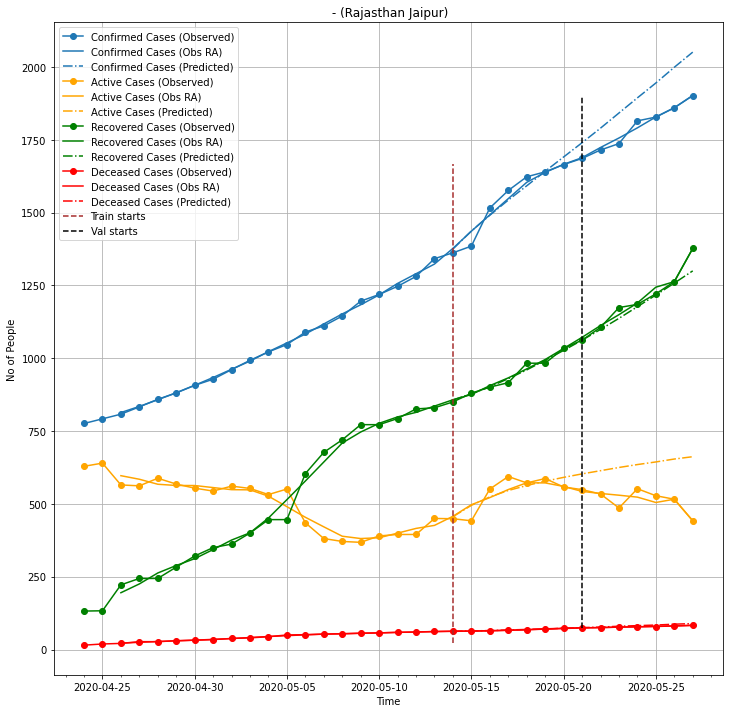

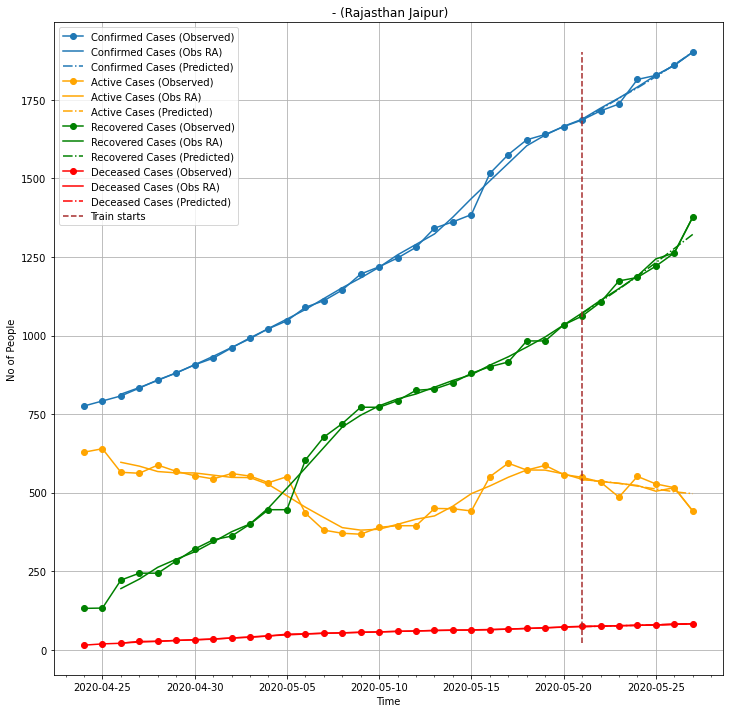

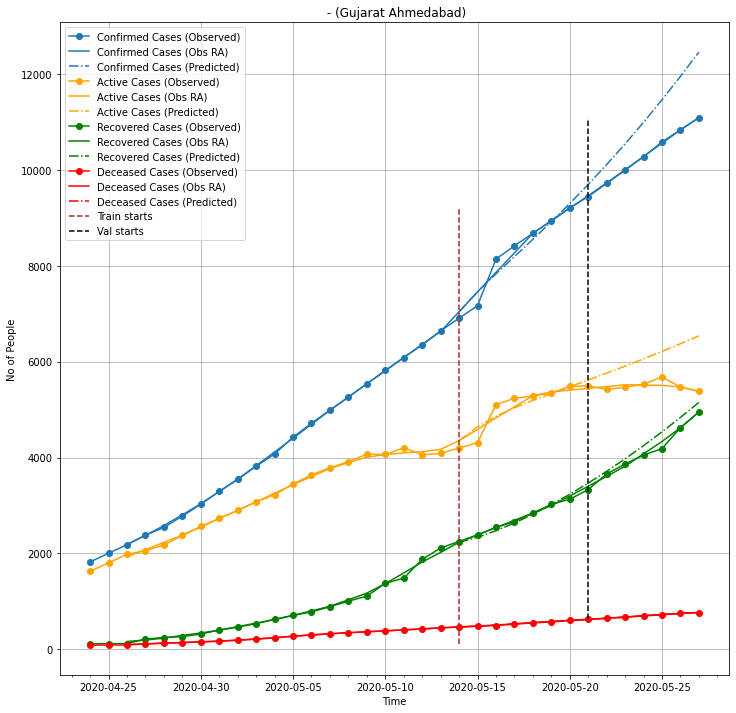

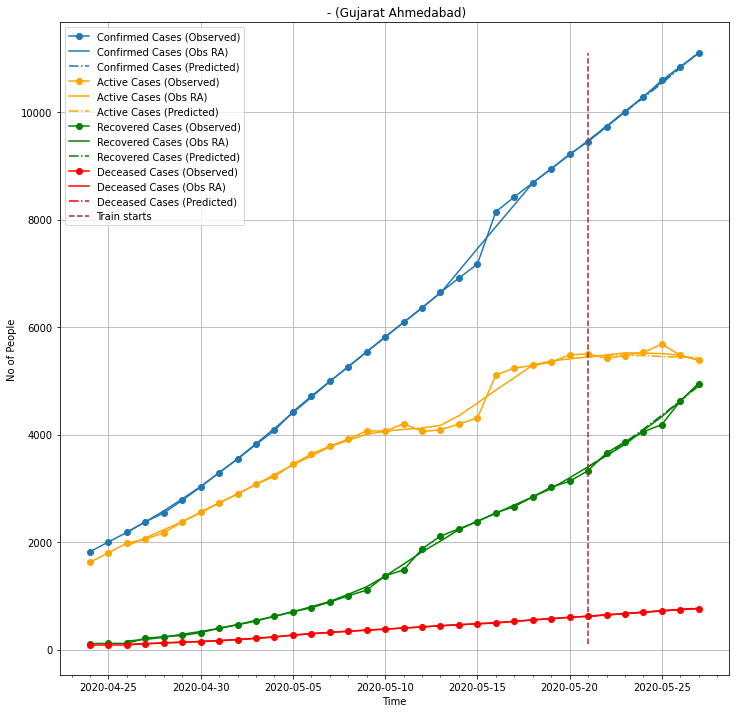

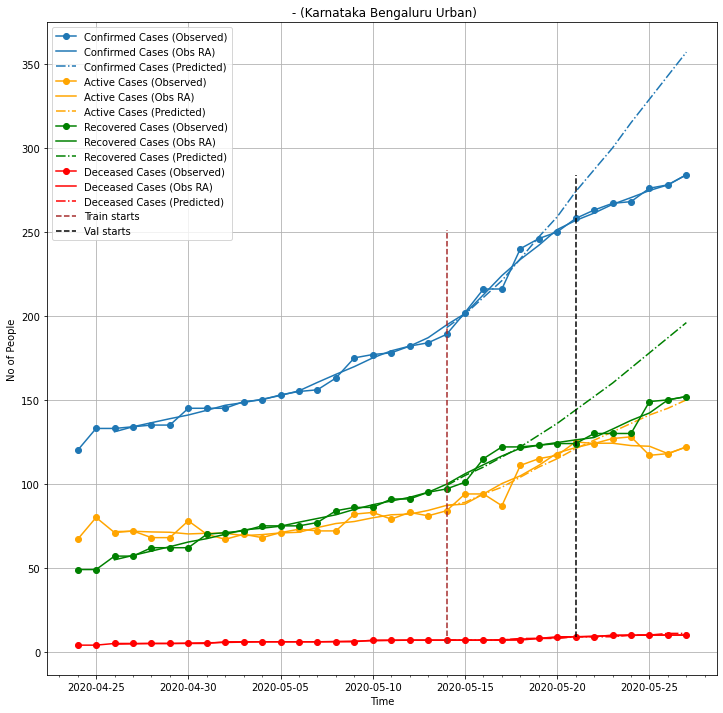

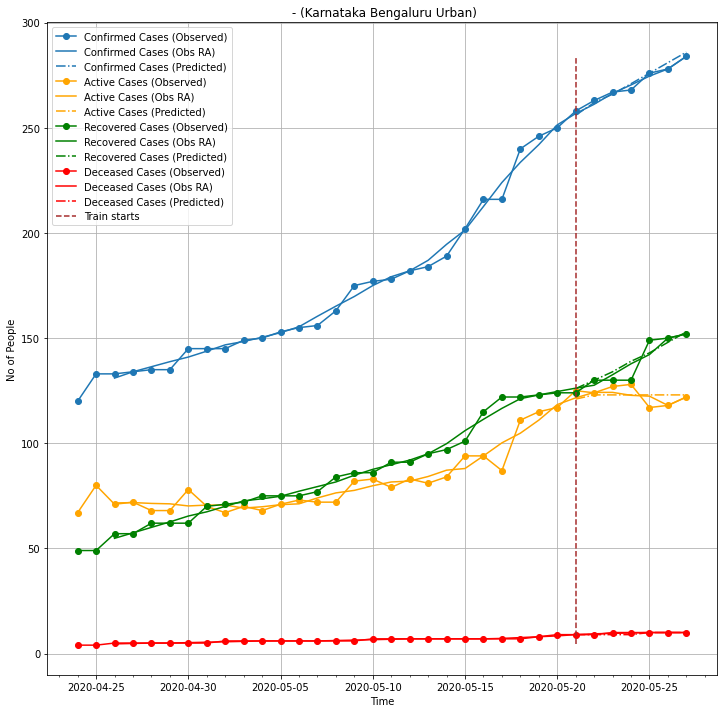

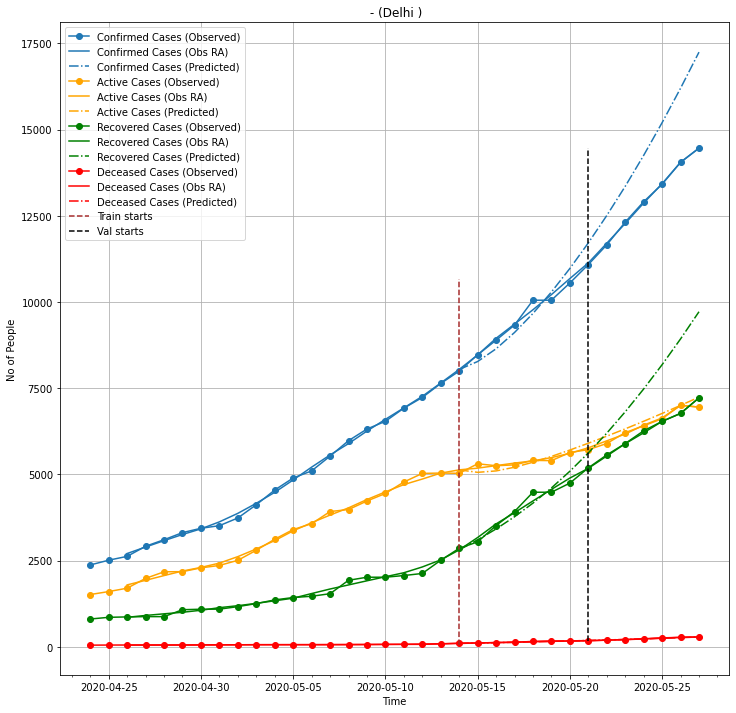

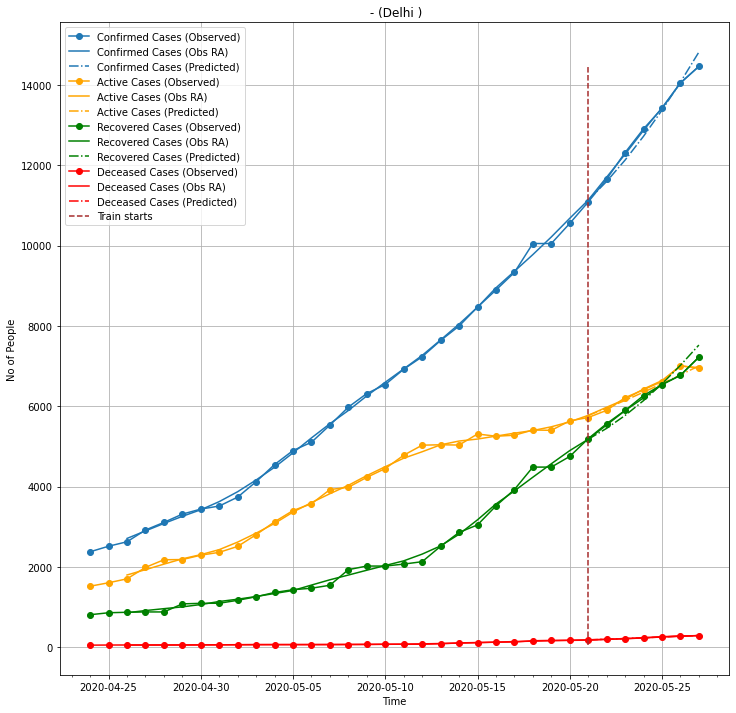

In [9]:
for state, district in districts_to_show:
    predictions_dict[(state, district)] = {}
    predictions_dict[(state, district)]['m1'] = single_fitting_cycle(dataframes, state, district, train_period=7, val_period=7, 
                                                                     data_from_tracker=True, initialisation='intermediate', num_evals=700,
                                                                     which_compartments=['hospitalised', 'total_infected', 'deceased', 'recovered'])
    predictions_dict[(state, district)]['m2'] = single_fitting_cycle(dataframes, state, district, train_period=7, val_period=0, num_evals=700,
                                                                     train_on_val=True, data_from_tracker=True, initialisation='intermediate',
                                                                     which_compartments=['hospitalised', 'total_infected', 'deceased', 'recovered'])
    predictions_dict[(state, district)]['state'] = state
    predictions_dict[(state, district)]['dist'] = district
    predictions_dict[(state, district)]['fitting_date'] = datetime.datetime.now().strftime("%Y-%m-%d")
    predictions_dict[(state, district)]['datasource'] = 'covid19api' if predictions_dict[(state, district)]['m1']['data_from_tracker'] else 'municipality'
    predictions_dict[(state, district)]['variable_param_ranges'] = predictions_dict[(state, district)]['m1']['variable_param_ranges']
    predictions_dict[(state, district)]['data_last_date'] = predictions_dict[(state, district)]['m2']['data_last_date']

## Create Master Loss Dataframe

### M1 Loss

In [11]:
starting_key = list(predictions_dict.keys())[0]

loss_columns = pd.MultiIndex.from_product([predictions_dict[starting_key]['m1']['df_loss'].columns, predictions_dict[starting_key]['m1']['df_loss'].index])
loss_index = predictions_dict.keys()

df_loss_master = pd.DataFrame(columns=loss_columns, index=loss_index)
for key in predictions_dict.keys():
    df_loss_master.loc[key, :] = np.around(predictions_dict[key]['m1']['df_loss'].values.T.flatten().astype('float'), decimals=2)
    
df_loss_master

train                                    \
                            hospitalised total_infected deceased recovered   
Maharashtra Pune                    2.01           1.25     1.23      3.08   
            Mumbai                  1.96           1.74     1.78      2.03   
Rajasthan   Jaipur                  4.99           1.71     1.29      0.96   
Gujarat     Ahmedabad               3.11           2.16      1.1      1.56   
Karnataka   Bengaluru Urban         4.76           1.95     3.57      4.15   
Delhi       NaN                     2.23           2.61     4.53      3.92   

                                     val                                    
                            hospitalised total_infected deceased recovered  
Maharashtra Pune                    7.71           4.06      2.6      3.15  
            Mumbai                  3.59           5.84     1.91     15.47  
Rajasthan   Jaipur                 18.52           5.34      4.4       1.6  
Gujarat     Ahmedabad               9.24            6.6     0.53      4.12  
Karnataka   Bengaluru Urban         9.73          13.66     4.18     18.39  
Delhi       NaN                     2.38          10.07     3.13     16.79

### M2 Loss

In [12]:
starting_key = list(predictions_dict.keys())[0]

loss_columns = pd.MultiIndex.from_product([predictions_dict[starting_key]['m2']['df_loss'].columns, predictions_dict[starting_key]['m2']['df_loss'].index])
loss_index = predictions_dict.keys()

df_loss_master = pd.DataFrame(columns=loss_columns, index=loss_index)
for key in predictions_dict.keys():
    df_loss_master.loc[key, :] = np.around(predictions_dict[key]['m2']['df_loss'].values.T.flatten().astype('float'), decimals=2)
    
df_loss_master

train                                  
                            hospitalised total_infected deceased recovered
Maharashtra Pune                    1.91           0.63     1.06       3.1
            Mumbai                  1.15           1.55     0.95       4.9
Rajasthan   Jaipur                   4.7           0.46     0.55       1.4
Gujarat     Ahmedabad                1.3           0.21     0.38      1.37
Karnataka   Bengaluru Urban         3.03           0.63     3.17      2.46
Delhi       NaN                     1.25           0.97     2.27      2.07

## Plot Forecasts

getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..


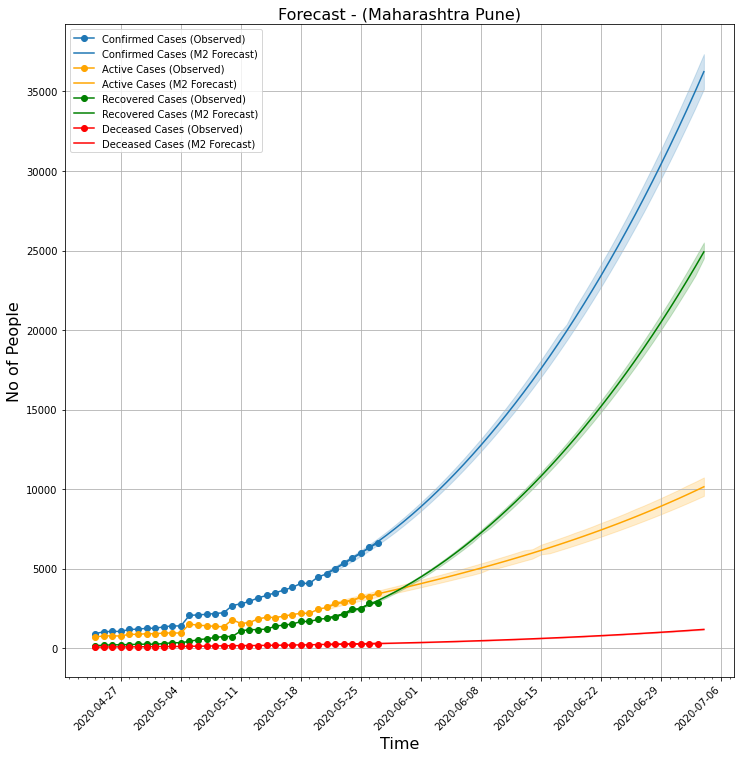

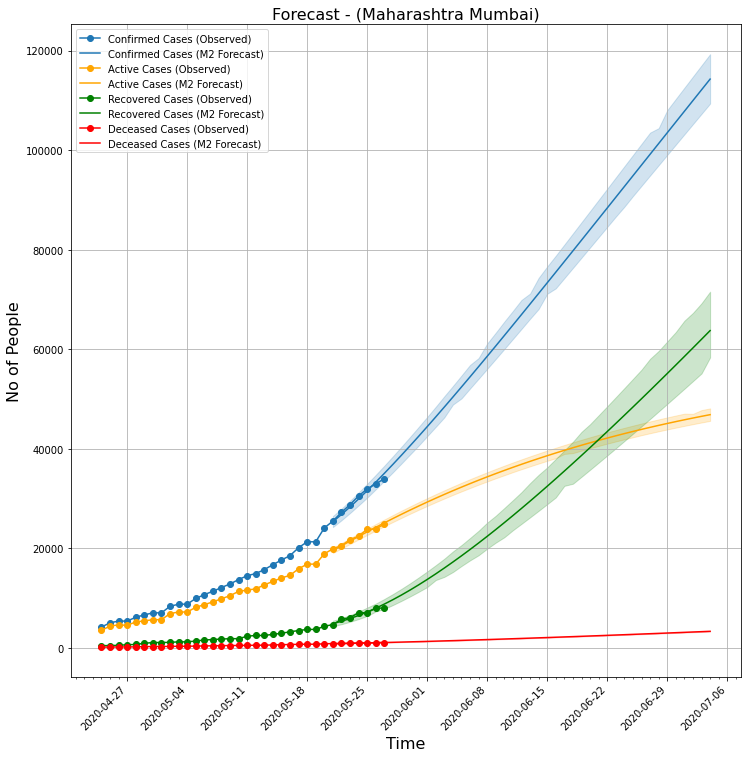

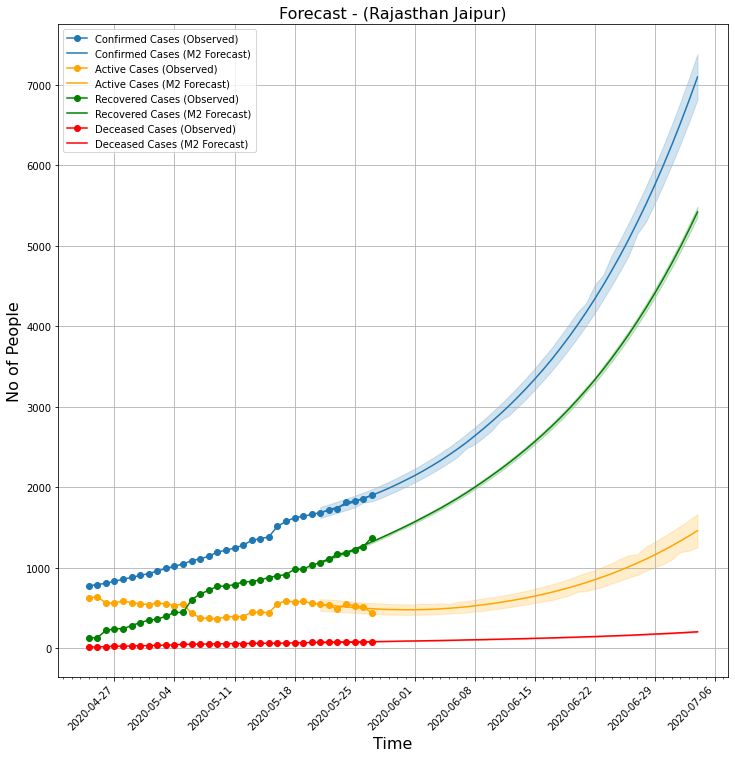

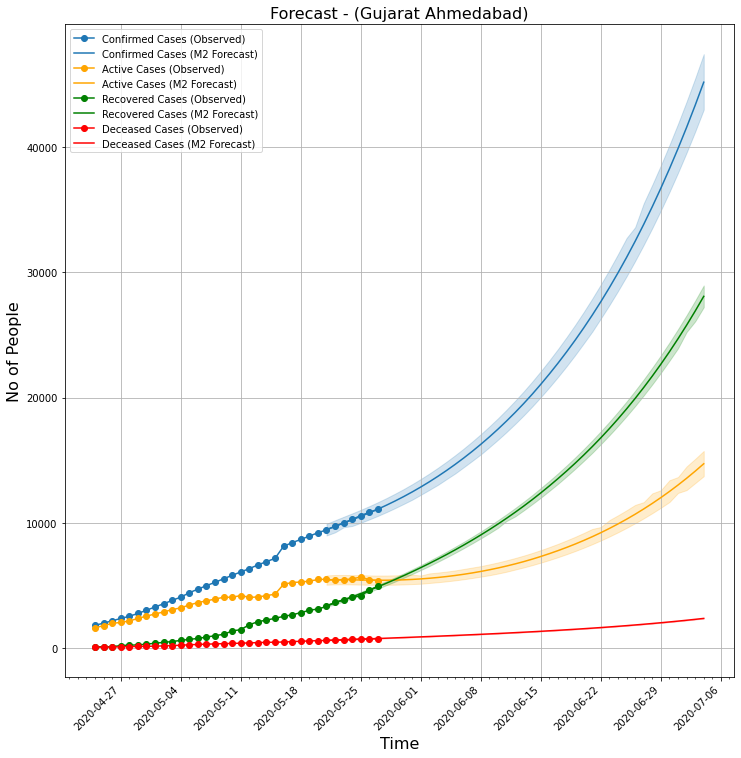

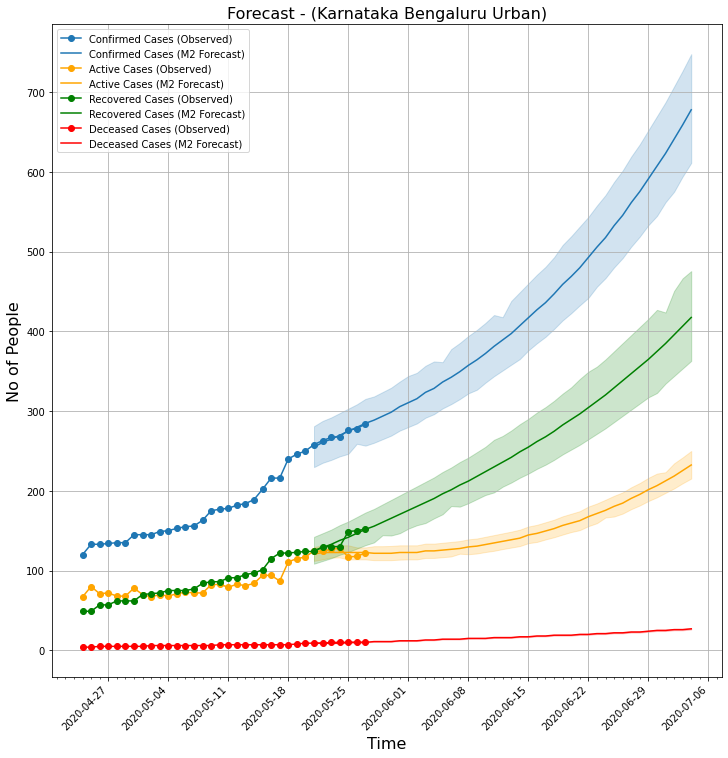

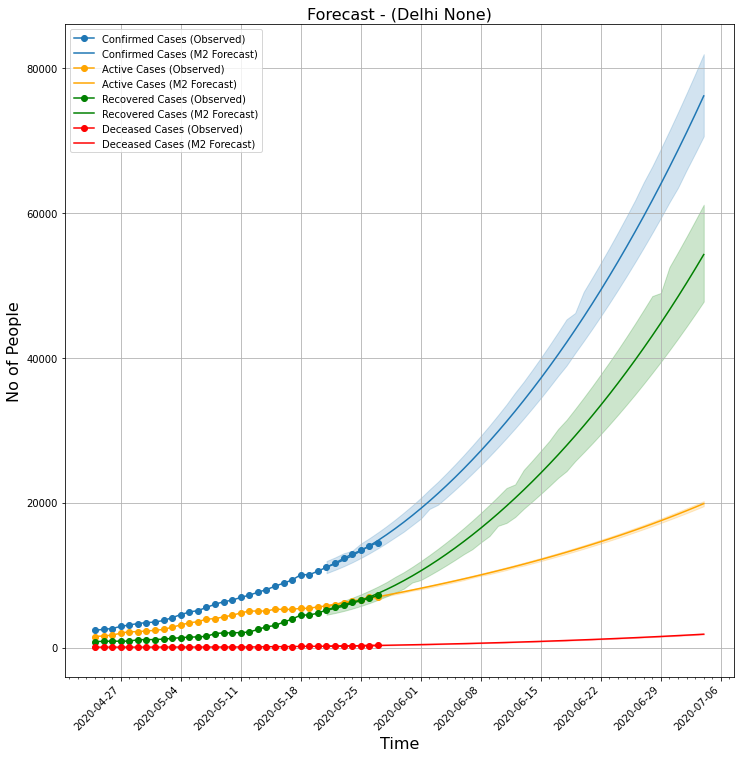

In [13]:
for region in predictions_dict.keys():
    predictions_dict[region]['forecast'] = plot_forecast(predictions_dict[region], region, both_forecasts=False, error_bars=True)

In [28]:
create_report(predictions_dict[('Maharashtra', 'Pune')])

## Create and Save Output CSV

In [85]:
df_output = create_all_csvs(predictions_dict, initialisation='intermediate', train_period=7, icu_fraction=0.02)

compiling csv data ..
getting forecasts ..
compiling csv data ..
getting forecasts ..
compiling csv data ..
getting forecasts ..
compiling csv data ..
getting forecasts ..
compiling csv data ..
getting forecasts ..
compiling csv data ..
getting forecasts ..
compiling csv data ..
getting forecasts ..


In [88]:
write_csv(df_output, '../../output-{}.csv'.format(datetime.datetime.now().strftime("%Y%m%d-%H%M%S")))